In [58]:
import os
import numpy as np
import pandas as pd
from nilearn import masking, image
from scipy.stats import ttest_1samp, pearsonr,ttest_ind,ttest_rel
import seaborn as sns
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
sns.set_theme(style="white")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.spines.right'] = False

## Plot the difference change with age for hexagonal modulation(noPhi)

In [59]:
# plot this in similar way with behavioural-age plot

# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data = participants_data.query('game2_fmri>=0.5')  # look out
subjects = data['Participant_ID'].to_list()

# set cmp template
cmap_temp1 = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/hexagon_spct/Setall/6fold/{}/zmap/hexagon_zmap.nii.gz'
cmap_temp2 = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game2/hexagon_spct/Setall/6fold/{}/zmap/hexagon_zmap.nii.gz'
sub_cmap1 = [cmap_temp1.format(sub) for sub in subjects]
sub_cmap2 = [cmap_temp2.format(sub) for sub in subjects]

# set roi
#roi = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/lh.isthmuscingulate.nii.gz')
#roi = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/rh.isthmuscingulate.nii.gz')
#roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
roi = image.load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/hexagon_spct/RSC_thr3.1_erosion2.nii.gz')

# extract mean activity of ROI for each subjects
sub_mact1 = np.mean(masking.apply_mask(sub_cmap1, roi), axis=1)
sub_mact2 = np.mean(masking.apply_mask(sub_cmap2, roi), axis=1)

data['game1_act'] = sub_mact1
data['game2_act'] = sub_mact2

<ipython-input-59-6486a3d70d27>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['game1_act'] = sub_mact1
<ipython-input-59-6486a3d70d27>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['game2_act'] = sub_mact2


<ipython-input-60-6b2f15ce7a51>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Age_group'] = pd.cut(data['Age'], bins=age_bins, labels=age_labels)


Age group: children, t: 1.5271861860364626, p: 0.12900348930392977
Age group: adolescents, t: -0.36391015042129693, p: 0.7166933831997968
Age group: adults, t: -2.453597281826876, p: 0.01535414237852094


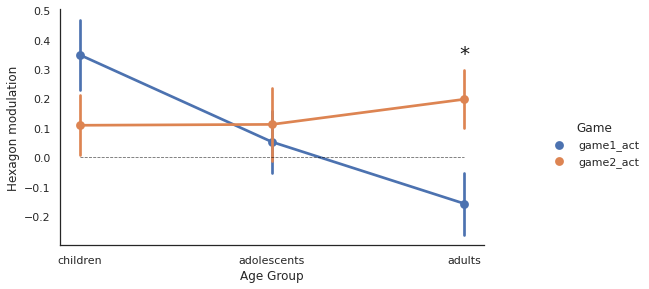

In [60]:
# Add age group categories
import math
age_bins = [7, 12, 17, 25]
age_labels = ['children', 'adolescents', 'adults']
data['Age_group'] = pd.cut(data['Age'], bins=age_bins, labels=age_labels)

# Melt the data for easier plotting
data_melted = data.melt(id_vars=['Age_group'], value_vars=['game1_act', 'game2_act'],
                        var_name='game', value_name='Hexagon modulation')

g = sns.catplot(x='Age_group', y='Hexagon modulation', hue='game', data=data_melted, kind='point', errorbar="se")
x = [0,1,2]
y = [0]*len(x)
plt.plot(x, y, linestyle='--', color='black',linewidth=0.8,alpha=0.6)
g.set_axis_labels("Age Group", "Hexagon modulation")
g._legend.set_title('Game')
#g._legend.set_bbox_to_anchor((0.3, 0.8))
g.fig.set_size_inches(10,4)

# compare accuracy between game1 and game2 for each age groups using t-tests
for index,age_group in enumerate(age_labels):
    game1 = data_melted[(data_melted['Age_group'] == age_group) & (data_melted['game'] == 'game1_act')]['Hexagon modulation']
    game2 = data_melted[(data_melted['Age_group'] == age_group) & (data_melted['game'] == 'game2_act')]['Hexagon modulation']
    t, p = ttest_ind(game1, game2)
    print('Age group: {}, t: {}, p: {}'.format(age_group, t, p))
    # add significance stars to the plot for each age group
    if p <= 0.001:
        g.ax.text(index,0.32,'***', ha='center', va='bottom', color='k', fontsize=20)
    elif p <= 0.01:
        g.ax.text(index,0.32,'**', ha='center', va='bottom', color='k', fontsize=20)
    elif p <= 0.05:
        g.ax.text(index,0.32,'*', ha='center', va='bottom', color='k', fontsize=20)
    else:
        g.ax.text(index,0.32,'', ha='center', va='bottom', color='k', fontsize=20)
# plot the neural difference with age

#### plot correlation between behavioural difference (game 1 vs. game 2) and neural difference (game1 vs. game2) , also also colour coded the dot based on age

<ipython-input-61-db7f09ac9980>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['neural_diff'] = data['game2_act'] - data['game1_act']
<ipython-input-61-db7f09ac9980>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['beh_diff'] = data['game2_test_acc'] - data['game1_acc']


<Figure size 432x288 with 0 Axes>

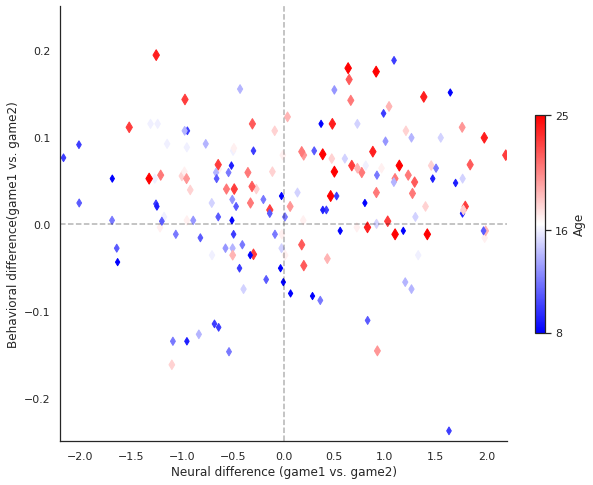

In [61]:
data['neural_diff'] = data['game2_act'] - data['game1_act']
data['beh_diff'] = data['game2_test_acc'] - data['game1_acc']

plt.clf()
fig, ax = plt.subplots(figsize=(10, 8))
ax.axvline(x=0, color='black', linestyle='--',alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--',alpha=0.3)
#sns.regplot(x='neural_diff', y='beh_diff', data=data, color='r',scatter=False,ci=None,line_kws={'alpha': 0.3})
age = data['Age']
s = [a*2+10 for a in age]
plt.scatter(x='neural_diff', y='beh_diff',data=data,c=age, cmap='bwr',marker='d',s=s)
plt.colorbar(label='Age',shrink=0.5,ticks=[8,16,25])
plt.xlim([-2.2,2.2])
plt.ylim([-0.25,0.25])
plt.xlabel('Neural difference (game1 vs. game2)')
plt.ylabel("Behavioral difference(game1 vs. game2)")
x = np.linspace(-2, 2)
y = x * -0.1
#ax.plot(x, y,color='black', linestyle='--',alpha=0.3)

In [62]:
# meidation analysis for hexagon modulation and age

# cmap_diff = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game2/distance_diff/Setall/6fold/{}/zmap/M2_corrxdistance_zmap.nii.gz'
# sub_cmap_diff = [cmap_diff.format(sub) for sub in subjects]
#
# # set roi
# roi1 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/lh.isthmuscingulate.nii.gz')
# roi2 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/rh.isthmuscingulate.nii.gz')
# roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)

# extract mean activity of ROI for each subjects
#sub_act_diff = np.mean(masking.apply_mask(sub_cmap_diff, roi), axis=1)
data['neural_diff'] = data['game2_act'] - data['game1_act']
data['beh_diff'] = data['game2_test_acc'] - data['game1_acc']

# The main effect for age to behavioral difference
X = data[['Age']]
Y = data['beh_diff']

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X)
model_summary = model.summary()
print(model_summary)

# The effect-a for age to behavioral difference
X = data[['Age']]
Y = data['neural_diff']

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X)
model_summary = model.summary()
print(model_summary)

# The effect-a for age to behavioral difference
X = data[['neural_diff']]
Y = data['beh_diff']

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X)
model_summary = model.summary()
print(model_summary)

# The effect-c' for age to behavioral difference
X = data[['Age','neural_diff']]
Y = data['beh_diff']

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X)
model_summary = model.summary()
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:               beh_diff   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     11.79
Date:                Thu, 11 May 2023   Prob (F-statistic):           0.000732
Time:                        13:36:56   Log-Likelihood:                 230.61
No. Observations:                 193   AIC:                            -457.2
Df Residuals:                     191   BIC:                            -450.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0228      0.016     -1.383      0.1

<ipython-input-62-fc1522d70420>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['neural_diff'] = data['game2_act'] - data['game1_act']
<ipython-input-62-fc1522d70420>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['beh_diff'] = data['game2_test_acc'] - data['game1_acc']


In [56]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats  import ttest_1samp
import statsmodels.formula.api as smf

def bootstrap_indirect_effect(data, iv, m, dv, n_bootstraps=5000, ci=0.95):
    indirect_effects = []
    for _ in range(n_bootstraps):
        bootstrap_data = data.sample(frac=1, replace=True)

        path_a = smf.ols(f"{m} ~ {iv}", data=bootstrap_data).fit()
        path_b = smf.ols(f"{dv} ~ {m} + {iv}", data=bootstrap_data).fit()

        indirect_effect = path_a.params[1] * path_b.params[1]
        indirect_effects.append(indirect_effect)

    lower = np.percentile(indirect_effects, (1 - ci) / 2 * 100)
    upper = np.percentile(indirect_effects, (1 + ci) / 2 * 100)

    return lower, upper,indirect_effects


# Replace 'IV', 'M', and 'DV' with the actual variable names in your dataset
iv = 'Age'
m = 'neural_diff'
dv = 'beh_diff'

# Path a: IV -> M
path_a = smf.ols(f"{m} ~ {iv}", data=data).fit()

# Path b: M -> DV, controlling for IV
path_b = smf.ols(f"{dv} ~ {m} + {iv}", data=data).fit()
lower, upper,indirect_effects = bootstrap_indirect_effect(data, iv, m, dv)
print(f"Bootstrapped {int(0.95 * 100)}% confidence interval for the indirect effect: ({lower:.8f}, {upper:.8f})")

Bootstrapped 95% confidence interval for the indirect effect: (-0.00009715, 0.00081827)


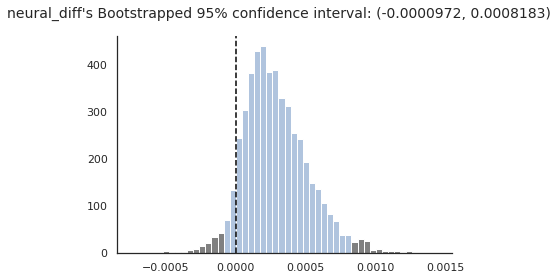

In [57]:
# Calculate lower and upper bounds
ci=0.95
lower = np.percentile(indirect_effects, (1 - ci) / 2 * 100)
upper = np.percentile(indirect_effects, (1 + ci) / 2 * 100)

# Plot histogram
fig, ax = plt.subplots()
n, bins, patches = ax.hist(indirect_effects, color='gray',bins=50)

# Find the bin with the highest frequency and its corresponding height
max_height = max(n)
max_height_index = np.where(n == max_height)[0][0]
max_height_bin = bins[max_height_index]

# Add vertical line at zero with height equal to the maximum frequency
ax.axvline(x=0, ymin=0, ymax=max_height, color='black', linestyle='--')

# Color the histogram between the lower and upper bounds blue
for i in range(len(patches)):
    if lower <= bins[i] < upper:
        patches[i].set_fc('lightsteelblue')

# Remove top and right spines
fig.suptitle(f"{m}'s Bootstrapped {int(ci * 100)}% confidence interval: ({lower:.7f}, {upper:.7f})",size=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [ ]:
# plot this in similar way with behavioural-age plot

# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data = participants_data.query('game2_fmri>=0.5')  # look out
data['beh_diff'] = data['game2_test_acc'] - data['game1_acc']
subjects = data['Participant_ID'].to_list()

# set cmp template
hexagon_diff_cmap = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game2/hexagon_diff/Setall/6fold/{}/zmap/hexagon_zmap.nii.gz'
hexagon_align_cmap = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game2/cv_hexagon_spct/Setall/6fold/{}/zmap/alignPhi_zmap.nii.gz'
distance_game2_cmap = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game2/distance_spct/Setall/6fold/{}/zmap/M2_corrxdistance_zmap.nii.gz'

sub_hexagon_diff_cmap = [hexagon_diff_cmap.format(sub) for sub in subjects]
sub_hexagon_align_cmap = [hexagon_align_cmap.format(sub) for sub in subjects]
sub_distance_game2_cmap = [distance_game2_cmap.format(sub) for sub in subjects]

# set roi
roi1 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/lh.isthmuscingulate.nii.gz')
roi2 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/rh.isthmuscingulate.nii.gz')
rsc_roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)

roi = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
ec = image.binarize_img(roi,10)

vmpfc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/VMPFC_merge_MNI152NL.nii.gz')

# extract mean activity of ROI for each subjects
data['hexagon_diff'] = np.mean(masking.apply_mask(sub_hexagon_diff_cmap, rsc_roi), axis=1)
data['hexagon_align'] = np.mean(masking.apply_mask(sub_hexagon_align_cmap, ec), axis=1)
data['distance_game2'] = np.mean(masking.apply_mask(sub_distance_game2_cmap, vmpfc), axis=1)

In [ ]:
X = data[['hexagon_diff','distance_game2']]
Y = data['beh_diff']

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X)
model_summary = model.summary()
print(model_summary)